<a href="https://colab.research.google.com/github/chloe-dg/NYC-Taxi-Fare-Prediction/blob/main/NY_City_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chloedg","key":"77feeebd0411c7a81242f4a137a78309"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 874kB/s]
100% 1.55G/1.56G [00:40<00:00, 37.0MB/s]
100% 1.56G/1.56G [00:40<00:00, 41.2MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 30.5MB/s]
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 102MB/s]


# Import libraries and inspect dataset

In [2]:
%matplotlib inline
import pathlib
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 500)
from collections import defaultdict

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None

from torch.nn import init
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

In [38]:
def haversine_distance(df, start_lat, end_lat, start_lng, end_lng, prefix):
    """
    calculates haversine distance between 2 sets of GPS coordinates in df
    """
    R = 6371  #radius of earth in kilometers
       
    phi1 = np.radians(df[start_lat])
    phi2 = np.radians(df[end_lat])
    
    delta_phi = np.radians(df[end_lat]-df[start_lat])
    delta_lambda = np.radians(df[end_lng]-df[start_lng])
    
        
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (R * c) #in kilometers
    df[prefix+'distance_km'] = d

def add_datepart(df, col, prefix):
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[prefix + n] = getattr(df[col].dt, n.lower())
    df[prefix + 'Elapsed'] = df[col].astype(np.int64) // 10 ** 9
    df.drop(col, axis=1, inplace=True)
    
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/(mdev if mdev else 1.)
    return s<m

def parse_gps(df, prefix):
    lat = prefix + '_latitude'
    lon = prefix + '_longitude'
    df[prefix + '_x'] = np.cos(df[lat]) * np.cos(df[lon])
    df[prefix + '_y'] = np.cos(df[lat]) * np.sin(df[lon]) 
    df[prefix + '_z'] = np.sin(df[lat])
    df.drop([lat, lon], axis=1, inplace=True)
    
def prepare_dataset(df):
    df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime, infer_datetime_format=True)
    add_datepart(df, 'pickup_datetime', 'pickup')
    haversine_distance(df, 'pickup_latitude', 'dropoff_latitude', 'pickup_longitude', 'dropoff_longitude', '')
    parse_gps(df, 'pickup')
    parse_gps(df, 'dropoff')
    df.dropna(inplace=True)
    y = np.log(df.fare_amount)
    df.drop(['key', 'fare_amount'], axis=1, inplace=True)
    
    return df, y

def split_features(df):
    catf = ['pickupYear', 'pickupMonth', 'pickupWeek', 'pickupDay', 'pickupDayofweek', 
            'pickupDayofyear', 'pickupHour', 'pickupMinute', 'pickupSecond', 'pickupIs_month_end',
            'pickupIs_month_start', 'pickupIs_quarter_end', 'pickupIs_quarter_start',
            'pickupIs_year_end', 'pickupIs_year_start']

    numf = [col for col in df.columns if col not in catf]
    for c in catf: 
        df[c] = df[c].astype('category').cat.as_ordered()
        df[c] = df[c].cat.codes+1
    
    return catf, numf

def numericalize(df):
    df[name] = col.cat.codes+1

def split_dataset(df, y): return train_test_split(df, y, test_size=0.25, random_state=42)

def inv_y(y): return np.exp(y)

def get_numf_scaler(train): return preprocessing.StandardScaler().fit(train)

def scale_numf(df, num, scaler):
    cols = numf
    index = df.index
    scaled = scaler.transform(df[numf])
    scaled = pd.DataFrame(scaled, columns=cols, index=index)
    return pd.concat([scaled, df.drop(numf, axis=1)], axis=1)

class RegressionColumnarDataset(data.Dataset):
    def __init__(self, df, cats, y):
        self.dfcats = df[cats]
        self.dfconts = df.drop(cats, axis=1)
        
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64)
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32)
        self.y = y.values.astype(np.float32)
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]
    
def rmse(targ, y_pred):
    return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) #.detach().numpy()

def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)

class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn=True):
        super().__init__()
        for i,(c,s) in enumerate(emb_szs): assert c > 1, f"cardinality must be >=2, got emb_szs[{i}]: ({c},{s})"
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: nn.init.kaiming_normal_(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        nn.init.kaiming_normal_(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = torch.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x.squeeze()

def fit(model, train_dl, val_dl, loss_fn, opt, scheduler, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description(f'Epoch {epoch}')
            
            opt.zero_grad()
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            loss.backward()
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            scheduler.step()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm_notebook(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

In [8]:
pip install dask

In [17]:

# start = time.time()
df = pd.read_csv('/content/train.csv',chunksize=1000000)
# end = time.time()
# print("Read csv with dask: ",(end-start),"sec")

In [25]:
df = pd.concat(df, ignore_index=True)

In [31]:
df.shape

(9785456, 8)

In [32]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [34]:
df['passenger_count'].describe()

count    9.785456e+06
mean     1.685222e+00
std      1.328278e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.080000e+02
Name: passenger_count, dtype: float64

In [35]:
df.passenger_count.quantile([.85, .99])

0.85    3.0
0.99    6.0
Name: passenger_count, dtype: float64

In [36]:
df.fare_amount.describe()

df.fare_amount.quantile([.85, .99])

count    9.785456e+06
mean     1.134041e+01
std      9.789630e+00
min     -3.000000e+02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      9.999900e+02
Name: fare_amount, dtype: float64

0.85    16.5
0.99    53.0
Name: fare_amount, dtype: float64

In [37]:
df = df.loc[(df.fare_amount > 0) & (df.passenger_count < 6) & (df.fare_amount < 53), :]

In [39]:
df, y = prepare_dataset(df)

df.shape
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: casting datetime64[ns, UTC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


(9482009, 24)

,passenger_count,pickupYear,pickupMonth,pickupWeek,pickupDay,pickupDayofweek,pickupDayofyear,pickupIs_month_end,pickupIs_month_start,pickupIs_quarter_end,pickupIs_quarter_start,pickupIs_year_end,pickupIs_year_start,pickupHour,pickupMinute,pickupSecond,pickupElapsed,distance_km,pickup_x,pickup_y,pickup_z,dropoff_x,dropoff_y,dropoff_z
0,2,2014,12,1,30,1,364,False,False,False,False,False,False,2,17,21,1419905841,7.108614,-0.166408,-0.983487,0.071151,-0.183380,-0.973977,0.133191
1,4,2015,2,7,12,3,43,False,False,False,False,False,False,7,47,15,1423727235,2.845515,-0.122967,-0.989938,0.070013,-0.156099,-0.985486,0.066718
2,1,2009,12,52,24,3,358,False,False,False,False,False,False,13,41,0,1261662060,3.133819,-0.158245,-0.984043,0.081347,-0.133884,-0.989151,0.060463
3,5,2010,1,4,29,4,29,False,False,False,False,False,False,14,25,0,1264775100,1.857491,-0.152693,-0.985129,0.078780,-0.144517,-0.985003,0.094259
4,1,2014,6,24,14,5,165,False,False,False,False,False,False,17,29,17,1402766957,1.802391,-0.141403,-0.986653,0.080757,-0.162480,-0.983442,0.080268


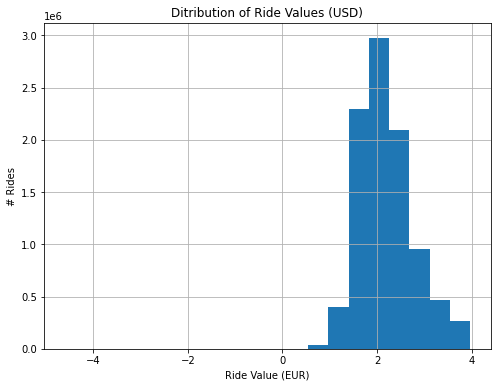

In [40]:
ax = y.hist(bins=20, figsize=(8,6))
_ = ax.set_xlabel("Ride Value (EUR)")
_ = ax.set_ylabel("# Rides")
_ = ax.set_title('Ditribution of Ride Values (USD)')

In [41]:
catf, numf = split_features(df)

len(catf)
catf

len(numf)
numf

15

['pickupYear',
 'pickupMonth',
 'pickupWeek',
 'pickupDay',
 'pickupDayofweek',
 'pickupDayofyear',
 'pickupHour',
 'pickupMinute',
 'pickupSecond',
 'pickupIs_month_end',
 'pickupIs_month_start',
 'pickupIs_quarter_end',
 'pickupIs_quarter_start',
 'pickupIs_year_end',
 'pickupIs_year_start']

9

['passenger_count',
 'pickupElapsed',
 'distance_km',
 'pickup_x',
 'pickup_y',
 'pickup_z',
 'dropoff_x',
 'dropoff_y',
 'dropoff_z']

In [42]:
X_train, X_test, y_train, y_test = split_dataset(df, y)

X_train.shape
X_test.shape

(7111506, 24)

(2370503, 24)

In [43]:
scaler = get_numf_scaler(X_train[numf])

X_train_sc = scale_numf(X_train, numf, scaler)
X_train_sc.std(axis=0)

passenger_count             1.000000
pickupElapsed               1.000000
distance_km                 1.000000
pickup_x                    1.000000
pickup_y                    1.000000
pickup_z                    1.000000
dropoff_x                   1.000000
dropoff_y                   1.000000
dropoff_z                   1.000000
pickupYear                  1.858007
pickupMonth                 3.434565
pickupWeek                 14.939796
pickupDay                   8.682561
pickupDayofweek             1.948519
pickupDayofyear           104.735223
pickupIs_month_end          0.178243
pickupIs_month_start        0.173582
pickupIs_quarter_end        0.103425
pickupIs_quarter_start      0.097650
pickupIs_year_end           0.048920
pickupIs_year_start         0.046125
pickupHour                  6.525323
pickupMinute               17.332798
pickupSecond               19.471095
dtype: float64

In [44]:
X_test_sc = scale_numf(X_test, numf, scaler)

X_train_sc.shape
X_test_sc.shape
X_test_sc.std(axis=0)

(7111506, 24)

(2370503, 24)

passenger_count             0.999009
pickupElapsed               1.000121
distance_km                 0.990449
pickup_x                    0.997651
pickup_y                    0.997936
pickup_z                    0.994029
dropoff_x                   0.996669
dropoff_y                   0.995689
dropoff_z                   0.995865
pickupYear                  1.858490
pickupMonth                 3.435794
pickupWeek                 14.944827
pickupDay                   8.687503
pickupDayofweek             1.949106
pickupDayofyear           104.771694
pickupIs_month_end          0.178777
pickupIs_month_start        0.173909
pickupIs_quarter_end        0.104115
pickupIs_quarter_start      0.097809
pickupIs_year_end           0.049174
pickupIs_year_start         0.046225
pickupHour                  6.526350
pickupMinute               17.331501
pickupSecond               19.475428
dtype: float64

# Defining pytorch datasets and dataloaders

In [45]:
trainds = RegressionColumnarDataset(X_train_sc, catf, y_train)
valds = RegressionColumnarDataset(X_test_sc, catf, y_test)

In [46]:
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 8}

traindl = data.DataLoader(trainds, **params)
valdl = data.DataLoader(valds, **params)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Defining model and related variables¶

In [47]:
y_range = (0, y_train.max()*1.2)
y_range

cat_sz = [(c, df[c].max()+1) for c in catf]
cat_sz

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

(0, 4.7632176864568985)

[('pickupYear', 8),
 ('pickupMonth', 13),
 ('pickupWeek', 54),
 ('pickupDay', 32),
 ('pickupDayofweek', 8),
 ('pickupDayofyear', 367),
 ('pickupHour', 25),
 ('pickupMinute', 61),
 ('pickupSecond', 61),
 ('pickupIs_month_end', 3),
 ('pickupIs_month_start', 3),
 ('pickupIs_quarter_end', 3),
 ('pickupIs_quarter_start', 3),
 ('pickupIs_year_end', 3),
 ('pickupIs_year_start', 3)]

[(8, 4),
 (13, 7),
 (54, 27),
 (32, 16),
 (8, 4),
 (367, 50),
 (25, 13),
 (61, 31),
 (61, 31),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2)]

In [48]:
m = MixedInputModel(emb_szs=emb_szs, 
                    n_cont=len(df.columns)-len(catf), 
                    emb_drop=0.04, 
                    out_sz=1, 
                    szs=[1000,500,250], 
                    drops=[0.001,0.01,0.01], 
                    y_range=y_range).to(device)

opt = optim.Adam(m.parameters(), 1e-2)
lr_cosine = lr_scheduler.CosineAnnealingLR(opt, 1000)

lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)

In [49]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(8, 4)
    (1): Embedding(13, 7)
    (2): Embedding(54, 27)
    (3): Embedding(32, 16)
    (4): Embedding(8, 4)
    (5): Embedding(367, 50)
    (6): Embedding(25, 13)
    (7): Embedding(61, 31)
    (8): Embedding(61, 31)
    (9): Embedding(3, 2)
    (10): Embedding(3, 2)
    (11): Embedding(3, 2)
    (12): Embedding(3, 2)
    (13): Embedding(3, 2)
    (14): Embedding(3, 2)
  )
  (lins): ModuleList(
    (0): Linear(in_features=204, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=250, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outp): Linear(in_features=250, out_features=1, bia